### Recurrent Neural Networks

$\mathrm{AR}$ 모형의 일반화된 과정으로써의 $\mathrm{RNN}$ Network를 알아보도록 한다

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import keras.initializers
from keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
from keras.models import Sequential
from keras.models import load_model
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split
#from skorch import NeuralNetRegressor

from recurrent_neural_network import *

#### Data Import

In [10]:
df = pd.read_csv('../data/coinbase.csv', index_col = 1)
df.index = pd.to_datetime(df.index)

In [11]:
df

,USD
timestamp,
2018-01-01 00:00:00,13598.814422
2018-01-01 00:01:00,13596.912824
2018-01-01 00:02:00,13568.356998
2018-01-01 00:03:00,13560.425182
2018-01-01 00:04:00,13552.270931
...,...
2018-11-10 15:56:00,6347.417225
2018-11-10 15:57:00,6347.419294
2018-11-10 15:58:00,6347.418653


data preprocessing

In [12]:
nof_missing_values = sum(np.isnan(df['USD']))

print(nof_missing_values, 'observations are missing.')
print('This is {:.3f}% of the total.'.format(nof_missing_values*100/len(df)))

1662 observations are missing.
This is 0.368% of the total.


In [13]:
df = df.bfill()
nof_missing_values = sum(np.isnan(df['USD']))
print('Now', nof_missing_values, 'observations are missing.')

Now 0 observations are missing.


#### RNN Regression

시계열이 Data Frame에서 'USD'로 주어지고 각 입력 시퀀스에 대해 미래의 4개의 시간 단계로 값을 예측하는 단변량 예측 문제를 고려한다

In [14]:
use_features = ['USD'] # continuous input
target = ['USD'] # continuous output
n_steps_ahead = 4 # forecasting horizon

In [15]:
sample = df['USD'][:200000]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [16]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -2.0945571633757587
p-value: 0.2467088183939536,
N: 199918, 
critical values: {'1%': -3.4303827103310676, '5%': -2.8615544575334875, '10%': -2.566777695225296}


ADF 검정을 통과하지 못하였음으로, 불안정 시계열이다

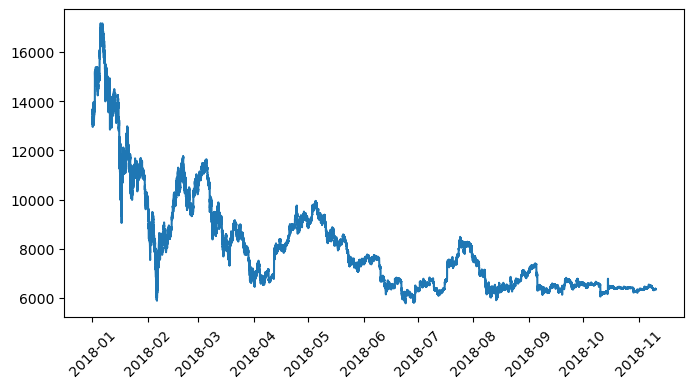

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,4))
plt.plot(df)
plt.grid(False)
plt.xticks(rotation = 45)
plt.show()

**Partial Auto-correlation**

A partial auto-correlation at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\begin{align}\tau_h&:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})\\
&:=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}},
\end{align}$$
where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where $T$ is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimate the PACF. The `nlags` parameter is the maximum number of lags used for PACF estimation.

In [19]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=30)

 $\Phi^{-1}(0.99) \simeq 2.58$ 이기 때문에, 다음이 성립한다

In [20]:
T = len(df[use_features])
sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

In [21]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 4


Text(0.5, 1.0, 'Partial Autocorrelation function')

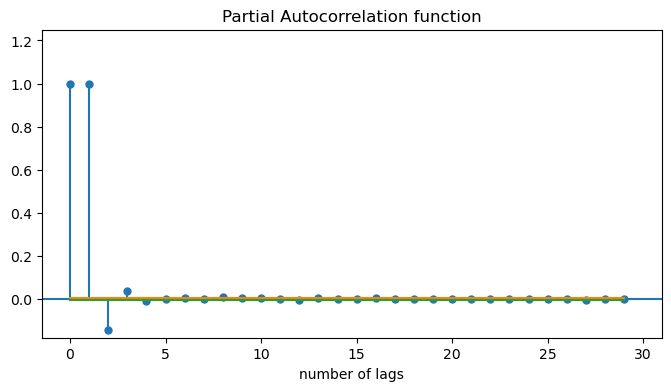

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(8, 4))
plot_pacf(np.log(df), auto_ylims = True, lags = 29, title = 'PACF of KOSPI log Index', ax = ax)
plt.xlabel('number of lags')
plt.plot([2.58/np.sqrt(T)] * 30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)] * 30, label='99% confidence interval (lower)')
plt.grid(False)
plt.title('Partial Autocorrelation function')

train - test split

In [24]:
train_weight = 0.8
split = int(len(df) * train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

In [27]:
# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
mu = np.float64(df_train.mean())
sigma = np.float64(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_47063/3391573592.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = np.float64(df_train.mean())
/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_47063/3391573592.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = np.float64(df_train.std())


In [28]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

In [29]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train = df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

In [30]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(361337, 4, 1), (361337, 1), (90330, 4, 1), (90330, 1)]


In [31]:
import torch
import torch.nn as nn
import numpy as np

class AlphatRNNCell(nn.Module):
    def __init__(self, input_size, units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 dropout=0.,
                 recurrent_dropout=0.):
        super(AlphatRNNCell, self).__init__()
        self.units = units
        self.input_size = input_size
        self.activation = nn.Tanh() if activation == 'tanh' else nn.ReLU()
        self.recurrent_activation = nn.Sigmoid() if recurrent_activation == 'sigmoid' else nn.ReLU()
        self.use_bias = use_bias
        self.dropout = nn.Dropout(dropout)
        self.recurrent_dropout = nn.Dropout(recurrent_dropout)

        # Define weights
        self.kernel = nn.Linear(input_size, units * 2, bias=use_bias)
        self.recurrent_kernel = nn.Linear(units, units * 2, bias=use_bias)

    def forward(self, input, states):
        h_tm1 = states[0]  # previous memory state

        # Apply dropout
        input = self.dropout(input)

        # Linear mappings
        matrix_x = self.kernel(input)
        matrix_inner = self.recurrent_kernel(h_tm1)

        # Partition weights into alpha and recurrent parts
        x_alpha, x_h = matrix_x.chunk(2, -1)
        recurrent_alpha, recurrent_h = matrix_inner.chunk(2, -1)

        # Activation functions
        alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
        hh = self.activation(x_h + recurrent_h)

        # Compute the current memory state
        h = alpha * h_tm1 + (1 - alpha) * hh
        return h, [h]

class AlphatRNN(nn.Module):
    def __init__(self, input_size, units,
                 activation='tanh',
                 recurrent_activation='sigmoid',
                 use_bias=True,
                 dropout=0.,
                 recurrent_dropout=0.,
                 return_sequences=False,
                 return_state=False):
        super(AlphatRNN, self).__init__()
        self.cell = AlphatRNNCell(input_size, units,
                                  activation=activation,
                                  recurrent_activation=recurrent_activation,
                                  use_bias=use_bias,
                                  dropout=dropout,
                                  recurrent_dropout=recurrent_dropout)
        self.return_sequences = return_sequences
        self.return_state = return_state

    def forward(self, inputs, initial_state=None):
        inputs = inputs.unbind(1)  # Convert inputs to a list of time steps
        outputs = []

        if initial_state is None:
            initial_state = torch.zeros(inputs[0].shape[0], self.cell.units, device=inputs[0].device)

        states = [initial_state]

        for input_t in inputs:
            h, states = self.cell(input_t, states)
            outputs.append(h)

        outputs = torch.stack(outputs, 1)  # (batch, time, units)

        if self.return_sequences:
            output = outputs
        else:
            output = outputs[:, -1, :]

        if self.return_state:
            return output, states
        else:
            return output

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AlphaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, alpha):
        super(AlphaRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.alpha = alpha
        
        # 가중치와 바이어스 초기화
        self.U_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b_h = nn.Parameter(torch.Tensor(hidden_size))
        
        self.W_y = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_y = nn.Parameter(torch.Tensor(hidden_size))
        
        self.init_weights()

    def init_weights(self):
        stdv = 1.0 / self.hidden_size ** 0.5
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def forward(self, input, hidden_states):
        h_tilde_prev, h_hat_prev = hidden_states
        
        # 혼합 은닉 상태 계산
        h_tilde = self.alpha * h_hat_prev + (1 - self.alpha) * h_tilde_prev
        
        # 현재 은닉 상태 업데이트
        h_hat = torch.sigmoid(self.U_h @ h_tilde + self.W_h @ input + self.b_h)
        
        # 출력 은닉 상태 예측
        h_next = self.W_y @ h_hat + self.b_y
        
        return h_next, (h_tilde, h_hat)

    def init_hidden(self):
        return (torch.zeros(self.hidden_size), torch.zeros(self.hidden_size))


In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def init_weights(m, seed=0, init_type='glorot_uniform'):
    torch.manual_seed(seed)
    if type(m) == nn.Linear or type(m) == nn.RNN or type(m) == nn.LSTM or type(m) == nn.GRU:
        if init_type == 'glorot_uniform':
            nn.init.xavier_uniform_(m.weight)
        elif init_type == 'orthogonal':
            nn.init.orthogonal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

class SequentialModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, rnn_class=nn.RNN, l1_reg=0):
        super(SequentialModel, self).__init__()
        self.rnn = rnn_class(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        # L1 regularization is not directly supported in PyTorch modules.
        # It needs to be manually implemented in the training loop if needed.
        self.l1_reg = l1_reg

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Assuming output_size=1 and taking the last sequence output
        return out

In [74]:
def alpha_t_RNN(input_size, n_units=10, l1_reg=0):
    return AlphatRNN(input_size, n_units)

def alpha_RNN(input_size, n_units=10, l1_reg=0):
    return AlphaRNN(input_size, n_units)

def simple_RNN(input_size, n_units=10, l1_reg=0):
    return SequentialModel(input_size, n_units, output_size=1, rnn_class=nn.RNN, l1_reg=l1_reg)

def gru(input_size, n_units=10, l1_reg=0):
    return SequentialModel(input_size, n_units, output_size=1, rnn_class=nn.GRU, l1_reg=l1_reg)

def lstm(input_size, n_units=10, l1_reg=0):
    return SequentialModel(input_size, n_units, output_size=1, rnn_class=nn.LSTM, l1_reg=l1_reg)

In [36]:
max_epochs = 1000
batch_size = 1000

In [42]:
import torch
import torch.nn as nn
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [43]:
es = EarlyStopping(monitor='valid_loss', patience=100, threshold=1e-7, threshold_mode='rel', lower_is_better=True)

In [48]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_test = torch.tensor(x_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

In [58]:
net = NeuralNetRegressor(
    module = simple_RNN(input_size=4),
    module__input_size=1,
    module__hidden_size=10,  # 초기값, 그리드 서치를 통해 최적화될 예정
    criterion=torch.nn.MSELoss,
    optimizer=torch.optim.Adam,
    max_epochs=10,  # 실제 사용 시 적절한 값으로 조정
    callbacks=[es],
    batch_size=64,  # 실제 사용 시 적절한 값으로 조정
    iterator_train__shuffle=True,
)

param_grid = {
    'module__hidden_size': [5, 10, 20],
    'lr': [0.01, 0.001, 0.0001],
}

tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(net, param_grid, refit=True, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(x_train, y_train)  # X_train, y_train은 PyTorch 텐서로 변환되어야 합니다.

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0500        0.0803  0.7368
      2        0.0006        0.0409  0.6553
      3        0.0006        0.0271  0.6511
      4        0.0006        0.0219  0.6557
      5        0.0006        0.0203  0.6436
      6        0.0006        0.0174  0.6380
      7        0.0006        0.0162  0.6420
      8        0.0006        0.0148  0.6184
      9        0.0006        0.0152  0.6205
     10        0.0006        0.0145  0.6207
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.0052        0.2794  1.2355
      2        0.0003        0.1916  1.2296
      3        0.0003        0.1554  1.2352
      4        0.0003        0.1641  1.2275
      5        0.0003        0.1476  1.2295
      6        0.0003        0.1520  1.2325
      7        0.0003        0.1569  1.2344
      8        0.0003        0.1329  1.2276
      9        0.0003        0.1

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=SequentialModel(
    (rnn): RNN(4, 10, batch_first=True)
    (fc): Linear(in_features=10, out_features=1, bias=True)
  ),
  module__hidden_size=10,
  module__input_size=1,
),
             param_grid={'lr': [0.01, 0.001, 0.0001],
                         'module__hidden_size': [5, 10, 20]},
             scoring='neg_mean_squared_error')

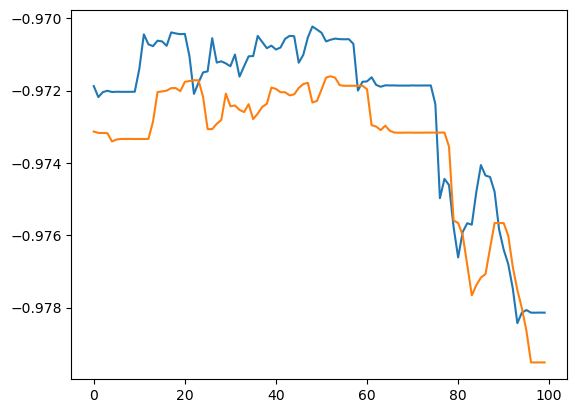

In [76]:
plt.plot(grid.predict(x_test)[-100:])
plt.plot(x_test.numpy()[:,0][-100:])

In [102]:
import warnings 
warnings.filterwarnings('ignore')
from torch.utils.data import DataLoader, TensorDataset

# 모델, 손실 함수, 옵티마이저 설정
model = AlphaRNN(4, 10, 0.5)
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

hidden_states = model.init_hidden()

In [144]:
for t in range(len(x_train)) :
    input_t = x_train[t]
    output, hidden_states = model(input_t, hidden_states)

In [105]:
# 예측
model.eval()  # 평가 모드
with torch.no_grad():
    predicted_stock_prices, _ = model(x_test, model.init_hidden())

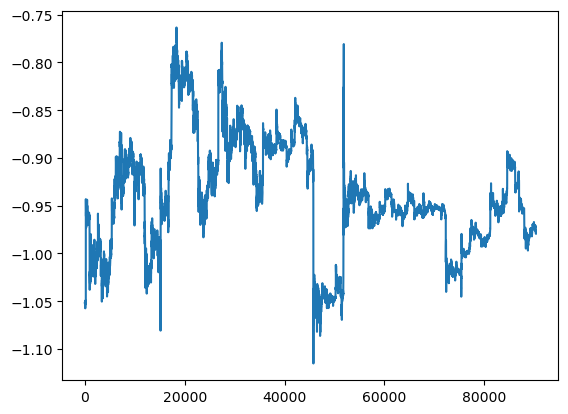

In [149]:
plt.plot(x_test.numpy()[:,0,0])

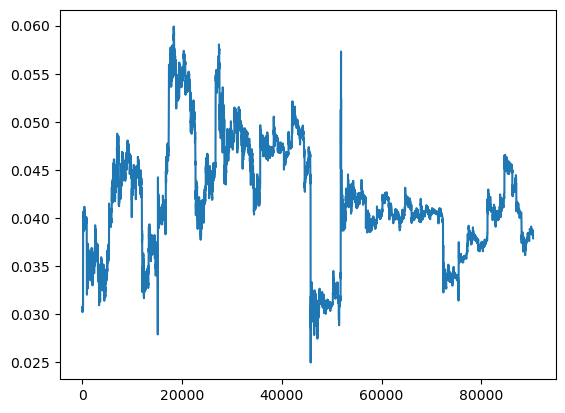

In [153]:
plt.plot(predicted_stock_prices.numpy()[:,1,0])